### Libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, precision_score, precision_recall_curve, roc_curve, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.inspection import permutation_importance
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.svm import SVC
import plotly.express as px

import category_encoders as encoder
import time

import pickle
from joblib import dump
from joblib import load

### Load Dataset

In [4]:
df = pd.read_csv('data/customer_churn_dataset.csv')

In [5]:
df.head(20)


,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,1,22,Female,25,14,4,27,Basic,Monthly,598,9,1
1,2,41,Female,28,28,7,13,Standard,Monthly,584,20,0
2,3,47,Male,27,10,2,29,Premium,Annual,757,21,0
3,4,35,Male,9,12,5,17,Premium,Quarterly,232,18,0
4,5,53,Female,58,24,9,2,Standard,Annual,533,18,0
5,6,30,Male,41,14,10,10,Premium,Monthly,500,29,0
6,7,47,Female,37,15,9,28,Basic,Quarterly,574,14,1
7,8,54,Female,36,11,0,18,Standard,Monthly,323,16,0
8,9,36,Male,20,5,10,8,Basic,Monthly,687,8,0
9,10,65,Male,8,4,2,23,Basic,Annual,995,10,0


In [6]:
df.shape

(64374, 12)

### Understanding the data

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64374 entries, 0 to 64373
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   CustomerID         64374 non-null  int64 
 1   Age                64374 non-null  int64 
 2   Gender             64374 non-null  object
 3   Tenure             64374 non-null  int64 
 4   Usage Frequency    64374 non-null  int64 
 5   Support Calls      64374 non-null  int64 
 6   Payment Delay      64374 non-null  int64 
 7   Subscription Type  64374 non-null  object
 8   Contract Length    64374 non-null  object
 9   Total Spend        64374 non-null  int64 
 10  Last Interaction   64374 non-null  int64 
 11  Churn              64374 non-null  int64 
dtypes: int64(9), object(3)
memory usage: 5.9+ MB


* CustomerID: A unique identifier for each customer
* Age: The age of the customer
* Gender: Gender of the customer
* Tenure: Duration in months for which a customer has been using the company's products or services
* Usage Frequency: Number of times that the customer has used the company’s services in the last month
* Support Calls: Number of calls that the customer has made to the customer support in the last month
* Payment Delay: Number of days that the customer has delayed their payment in the last month
* Subscription Type: Type of subscription the customer has chosen
* Contract Length: Duration of the contract that the customer has signed with the company
* Total Spend: Total amount of money the customer has spent on the company's products or services
* Last Interaction: Number of days since the last interaction that the customer had with the company
* Churn: Binary label indicating whether a customer has churned (1) or not (0)

### Categorical Data

In [8]:
cat_list =  df.select_dtypes(['object']).columns.tolist()
cat_list

['Gender', 'Subscription Type', 'Contract Length']

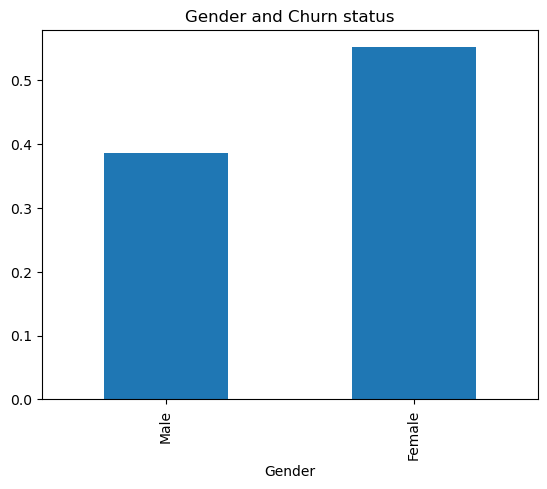

,Gender,count
0,Female,34353
1,Male,30021


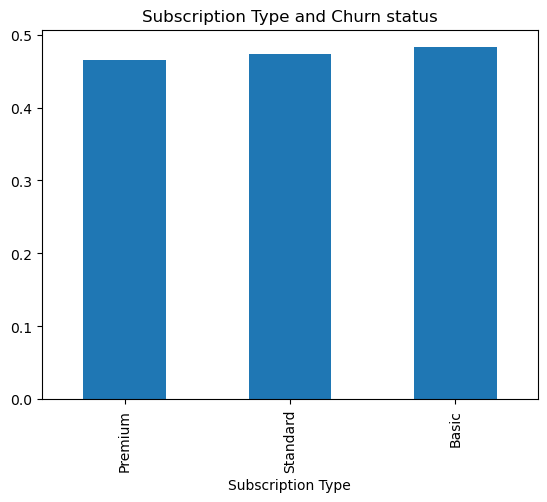

,Subscription Type,count
0,Standard,21502
1,Basic,21451
2,Premium,21421


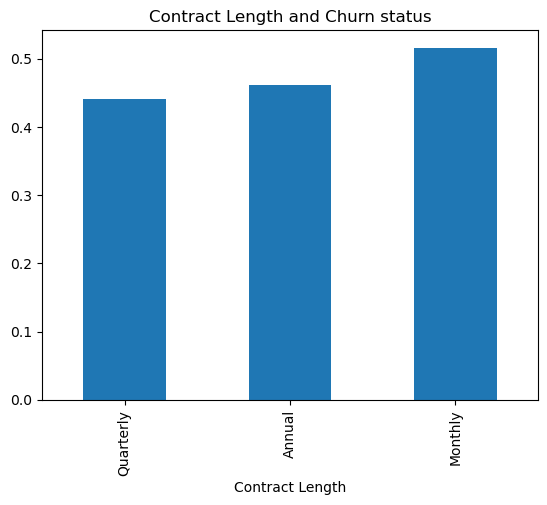

,Contract Length,count
0,Monthly,22130
1,Annual,21410
2,Quarterly,20834


In [9]:
for cat in cat_list:
    df.groupby(cat)['Churn'].mean().sort_values().plot(kind = 'bar', title = f'{cat} and Churn status');
    plt.show();
    temp_cat_df = df[cat].value_counts().reset_index().sort_values(by = 'count', ascending = False)
    display(temp_cat_df)

In [10]:

for cat in cat_list: 
    display(pd.crosstab(df[cat], df['Churn'], normalize ='index')
    .style
    .background_gradient(cmap= None, axis='index')
    )

Churn,0,1
Gender,,
Female,0.449510,0.550490
Male,0.614203,0.385797


Churn,0,1
Subscription Type,,
Basic,0.517225,0.482775
Premium,0.535036,0.464964
Standard,0.526695,0.473305


Churn,0,1
Contract Length,,
Annual,0.537833,0.462167
Monthly,0.483913,0.516087
Quarterly,0.559518,0.440482


### Cleaning Data

In [12]:
df.isna().sum() # gives total missing values

CustomerID           0
Age                  0
Gender               0
Tenure               0
Usage Frequency      0
Support Calls        0
Payment Delay        0
Subscription Type    0
Contract Length      0
Total Spend          0
Last Interaction     0
Churn                0
dtype: int64

In [13]:
df.isna().mean() # gives the nulls percentage

CustomerID           0.0
Age                  0.0
Gender               0.0
Tenure               0.0
Usage Frequency      0.0
Support Calls        0.0
Payment Delay        0.0
Subscription Type    0.0
Contract Length      0.0
Total Spend          0.0
Last Interaction     0.0
Churn                0.0
dtype: float64

In [15]:
df.duplicated().value_counts() # gives the features with duplicates

False    64374
Name: count, dtype: int64

### Correlations and distributions

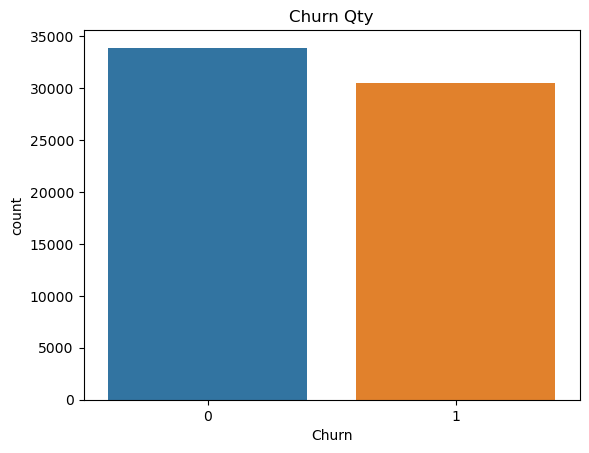

In [16]:

sns.countplot(data = df, x = df["Churn"]).set_title("Churn Qty")
plt.xlabel('Churn')
plt.show()

[Text(0.5, 1.0, 'Features Correlation')]

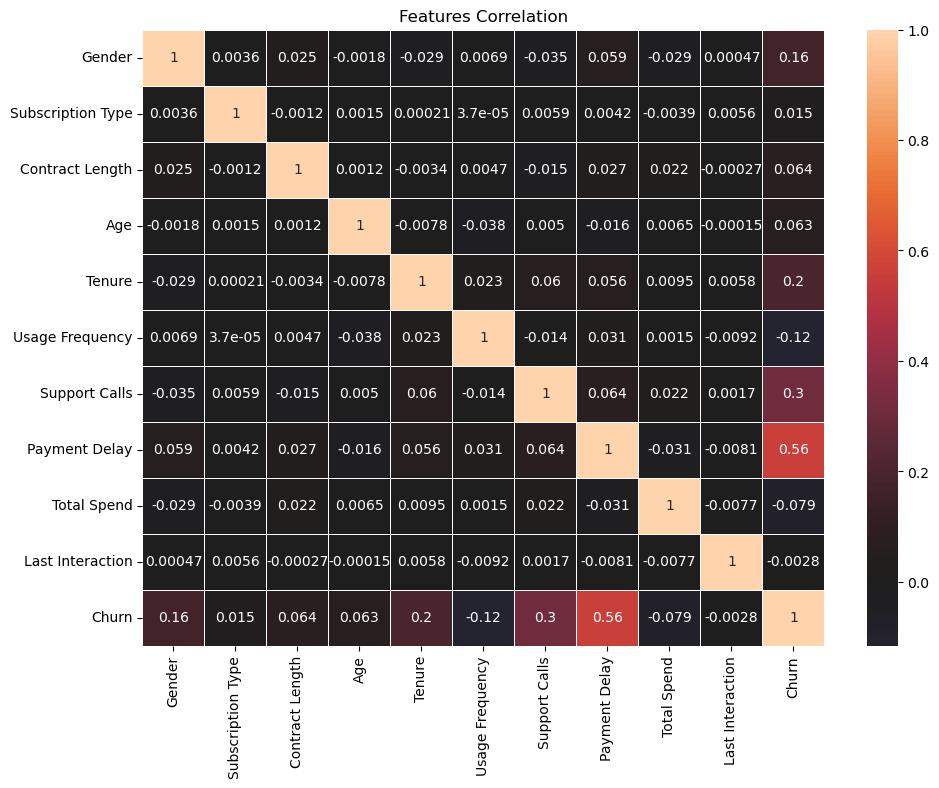

In [24]:

trg_enc = encoder.TargetEncoder()
ord_list = ['Age','Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Total Spend','Last Interaction', 'Churn']
df_final = pd.concat(
    [
        trg_enc.fit_transform(df[cat_list], df["Churn"]), 
        df[ord_list]
    ], 
    axis = 1)

df_final
# Run the correlation 
corr_data = df_final.corr()
corr_data

f, ax = plt.subplots(figsize=(11, 8))
sns.heatmap(corr_data, center = 0, linewidth = .5, annot = True).set(title='Features Correlation')

### Encoder categorical data

In [25]:

df_encoder = encoder.OrdinalEncoder(cols = cat_list).fit_transform(df)
df_encoder

,CustomerID,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction,Churn
0,1,22,1,25,14,4,27,1,1,598,9,1
1,2,41,1,28,28,7,13,2,1,584,20,0
2,3,47,2,27,10,2,29,3,2,757,21,0
3,4,35,2,9,12,5,17,3,3,232,18,0
4,5,53,1,58,24,9,2,2,2,533,18,0
...,...,...,...,...,...,...,...,...,...,...,...,...
64369,64370,45,1,33,12,6,21,1,3,947,14,1
64370,64371,37,2,6,1,5,22,2,2,923,9,1
64371,64372,25,2,39,14,8,30,3,1,327,20,1
64372,64373,50,1,18,19,7,22,2,1,540,13,1


### Train/Test Split data

In [26]:
X = df_encoder[['Age', 'Gender', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay', 'Subscription Type', 'Contract Length', 'Total Spend', 'Last Interaction']]
y = df_encoder['Churn']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
display(X_train)
display(y_train)

,Age,Gender,Tenure,Usage Frequency,Support Calls,Payment Delay,Subscription Type,Contract Length,Total Spend,Last Interaction
5871,54,1,7,29,0,27,3,2,568,16
40570,61,1,49,10,10,0,3,2,151,21
200,36,2,24,29,1,26,3,1,566,8
64037,59,1,27,12,9,24,1,1,257,9
13249,30,1,18,8,0,24,3,1,997,17
...,...,...,...,...,...,...,...,...,...,...
62570,50,2,38,11,5,28,3,3,568,5
38158,53,2,44,30,3,3,3,1,447,21
860,33,1,47,9,2,26,2,3,454,6
15795,24,2,57,19,10,9,3,2,948,27


5871     0
40570    0
200      0
64037    1
13249    1
        ..
62570    1
38158    0
860      1
15795    0
56422    1
Name: Churn, Length: 45061, dtype: int64

In [43]:
# Create a list and function to save the results
results_list = []
def process_model(key, model_func):
    start_time = time.time()
    model = model_func.fit(X_train, y_train)
    train_time = time.time() - start_time

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # scores
    ps = precision_score(y_test, y_test_pred, zero_division=0)
    rc = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    print("Precision: {:.2f}".format(ps))
    print("Recall: {:.2f}".format(rc))
    print("Accuracy: {:.2f}".format(test_acc))
    print("F1: {:.2f}".format(f1))
    print("time: {:.2f}".format(train_time))

    print("The accuracy train {:.2%}".format(train_acc))
    print("The accuracy test {:.2%}".format(test_acc))

    results_list.append({
        'Model': key,
        'Train Time': round(train_time,2),
        'Train Accuracy':  round(train_acc,2),
        'Test Accuracy':  round(test_acc,2),
        'Recall':  round(rc,2),
        'F1':  round(f1,2),
        'Precision':  round(ps,2)
    })


    confusion_mat = confusion_matrix(y_test, y_test_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=['No', 'Yes' ])
    disp.plot()
    plt.show()

    return ps, rc, f1, train_acc, test_acc

### Base Model

Precision: 0.00
Recall: 0.00
Accuracy: 0.52
F1: 0.00
time: 0.00
The accuracy train 52.70%
The accuracy test 52.47%


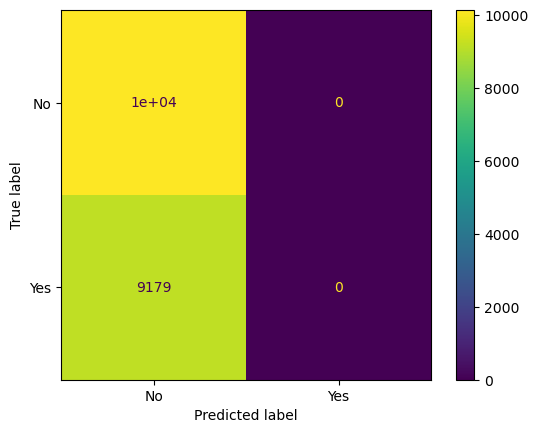

(0.0, 0.0, 0.0, 0.526996737755487, 0.5247242789830684)

In [44]:
# Use the DummyClassifier
process_model('Dummy', DummyClassifier(strategy= "prior"))

### Simples Models

Precision: 0.82
Recall: 0.83
Accuracy: 0.83
F1: 0.82
time: 1.79
The accuracy train 82.52%
The accuracy test 82.88%


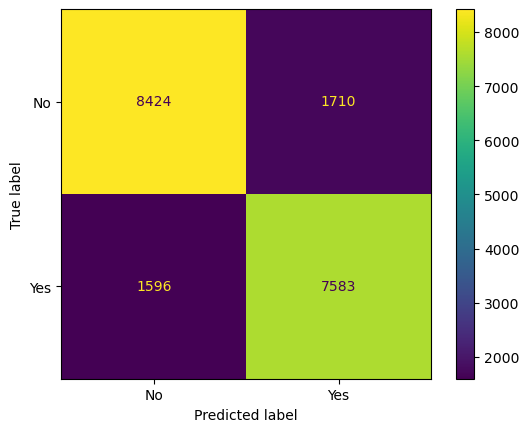

(0.8159905305068331,
 0.826124850201547,
 0.8210264183629277,
 0.8251703246710015,
 0.8288199658261275)

In [45]:
#Use a simple model Logistic Regression
result_lr = process_model('Logistic Regression', LogisticRegression(max_iter=1000000))
result_lr

Precision: 0.78
Recall: 0.84
Accuracy: 0.81
F1: 0.81
time: 0.02
The accuracy train 87.60%
The accuracy test 81.02%


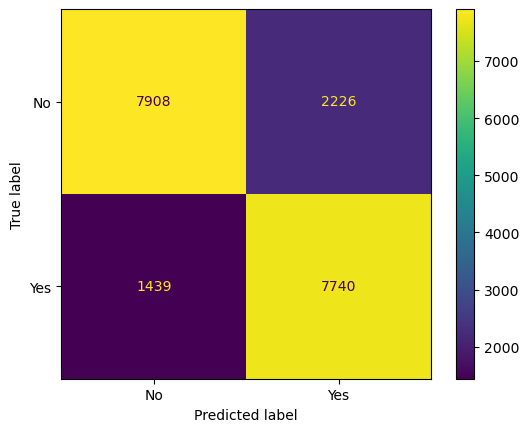

(0.7766405779650812,
 0.8432291099248284,
 0.8085662052755289,
 0.8759903242271587,
 0.8102314503184384)

In [46]:
process_model('KNN',KNeighborsClassifier())

Precision: 1.00
Recall: 1.00
Accuracy: 1.00
F1: 1.00
time: 0.05
The accuracy train 100.00%
The accuracy test 99.82%


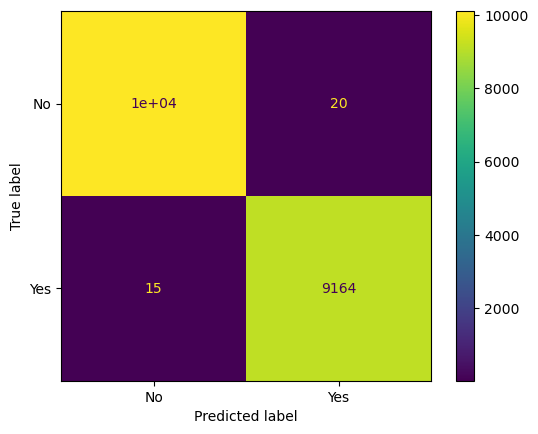

(0.997822299651568,
 0.9983658350582852,
 0.9980939933562055,
 1.0,
 0.9981877491844872)

In [47]:
process_model('DecisionTreeClassifier',DecisionTreeClassifier())

Precision: 0.79
Recall: 0.85
Accuracy: 0.82
F1: 0.82
time: 26.46
The accuracy train 81.49%
The accuracy test 81.92%


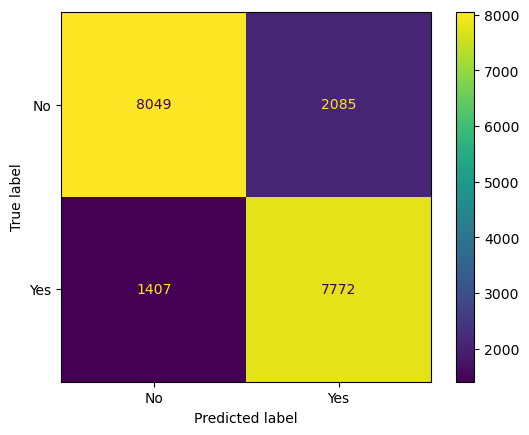

(0.7884751952926854,
 0.8467153284671532,
 0.8165581004412691,
 0.8148731719225051,
 0.8191891472065448)

In [48]:
process_model('SVM',SVC())

In [49]:
def process_model_grid(key, model_func, X_train, y_train, X_test, y_test):

    start_time = time.time()
    model = model_func.fit(X_train, y_train)
    train_time = time.time() - start_time

    y_train_pred = model.best_estimator_.predict(X_train)
    y_test_pred = model.best_estimator_.predict(X_test)
    
    # scores
    ps = precision_score(y_test, y_test_pred, zero_division=0)
    rc = recall_score(y_test, y_test_pred)
    f1 = f1_score(y_test, y_test_pred)
    train_acc = model.best_estimator_.score(X_train, y_train)
    test_acc =  model.best_estimator_.score(X_test, y_test)

    print("Precision: {:.2f}".format(ps))
    print("Recall: {:.2f}".format(rc))
    print("Accuracy: {:.2f}".format(test_acc))
    print("F1: {:.2f}".format(f1))
    print("time: {:.2f}".format(train_time))
    print(model_func.best_estimator_)

    print("The accuracy train {:.2%}".format(train_acc))
    print("The accuracy test {:.2%}".format(test_acc))

    results_list.append({
        'Model': key,
        'Train Time': round(train_time,2),
        'Train Accuracy':  round(train_acc,2),
        'Test Accuracy':  round(test_acc,2),
        'Recall':  round(rc,2),
        'F1':  round(f1,2),
        'Precision':  round(ps,2)
    })

    confusion_mat = confusion_matrix(y_test, y_test_pred, labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=['No', 'Yes' ])
    disp.plot()
    plt.show()

    #return ps, rc, f1, train_acc, test_acc, train_time
    return model.best_estimator_

Precision: 0.82
Recall: 0.83
Accuracy: 0.83
F1: 0.82
time: 1.74
Pipeline(steps=[('scaler', StandardScaler()),
                ('lr', LogisticRegression(solver='liblinear'))])
The accuracy train 82.52%
The accuracy test 82.88%


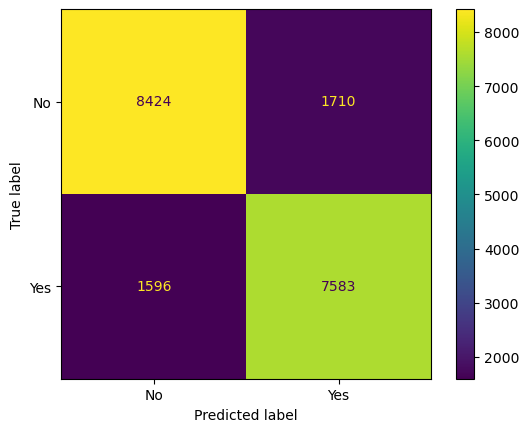

Pipeline(steps=[('scaler', StandardScaler()),
                ('lr', LogisticRegression(solver='liblinear'))])

In [50]:
param_grid_log = {
    'lr__solver': ['lbfgs', 'liblinear'],
    'lr__max_iter': [100, 200, 300,1000]  
}

pipe_logistic = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression())
])
process_model_grid('Logistic Regression Grid', GridSearchCV(estimator=pipe_logistic, param_grid=param_grid_log, cv=5), X_train, y_train, X_test, y_test)

Precision: 0.91
Recall: 0.95
Accuracy: 0.93
F1: 0.93
time: 8326.02
Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=12, p=1))])
The accuracy train 95.02%
The accuracy test 93.06%


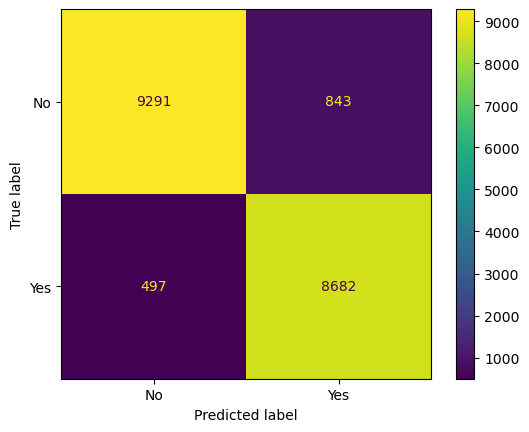

Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=12, p=1))])

In [51]:
param_grid_knn = {
    'knn__n_neighbors': list(range(1, 22, 1)),
    'knn__weights': ['uniform'],
    'knn__p': [1, 2]
}

pipe_KNN = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])
process_model_grid('KNN Grid', GridSearchCV(estimator=pipe_KNN, param_grid=param_grid_knn, cv=5), X_train, y_train, X_test, y_test)

Precision: 1.00
Recall: 1.00
Accuracy: 1.00
F1: 1.00
time: 3152.23
Pipeline(steps=[('scaler', StandardScaler()),
                ('d_tree',
                 DecisionTreeClassifier(criterion='entropy', max_depth=20,
                                        min_samples_split=8))])
The accuracy train 99.95%
The accuracy test 99.84%


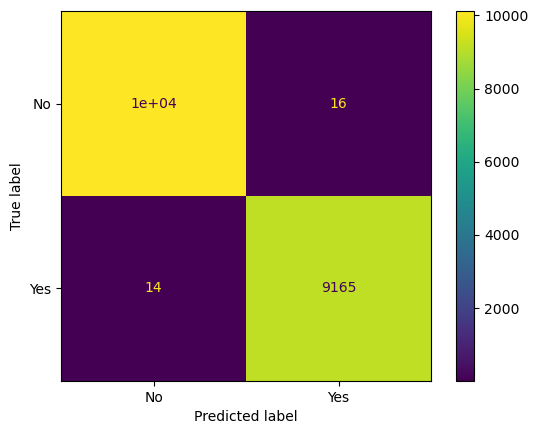

Pipeline(steps=[('scaler', StandardScaler()),
                ('d_tree',
                 DecisionTreeClassifier(criterion='entropy', max_depth=20,
                                        min_samples_split=8))])

In [52]:
param_grid_decision_tree = {
    'd_tree__max_depth': [None, 5, 10, 15, 20, 30],
    'd_tree__min_samples_split': [2, 4,8,10, 20],
    'd_tree__criterion': ['gini', 'entropy'],
    'd_tree__min_samples_leaf': [1, 2, 3, 4]
}


pipe_decision_tree = Pipeline([
    ('scaler', StandardScaler()),
    ('d_tree', DecisionTreeClassifier())
])

process_model_grid('DecisionTreeClassifier Grid', GridSearchCV(estimator=pipe_decision_tree, param_grid=param_grid_decision_tree, cv=5), X_train, y_train, X_test, y_test)

/Users/ronalcamilocuellar/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/ronalcamilocuellar/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/ronalcamilocuellar/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/ronalcamilocuellar/anaconda3/lib/python3.11/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/ronalcamilocuellar/anaconda3/

Precision: 0.63
Recall: 0.87
Accuracy: 0.70
F1: 0.73
time: 7500.33
Pipeline(steps=[('scaler', StandardScaler()),
                ('svc',
                 SVC(gamma=1.0, kernel='poly', max_iter=1000,
                     probability=True))])
The accuracy train 69.23%
The accuracy test 70.02%


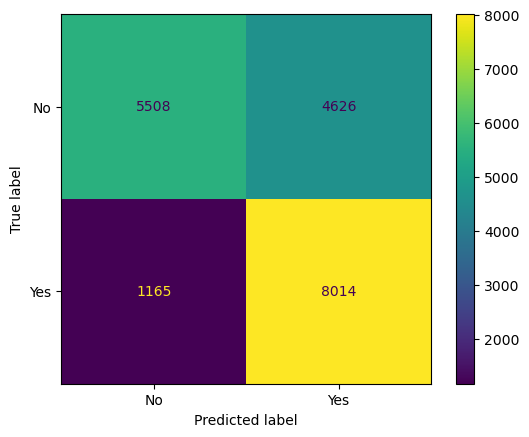

Pipeline(steps=[('scaler', StandardScaler()),
                ('svc',
                 SVC(gamma=1.0, kernel='poly', max_iter=1000,
                     probability=True))])

In [53]:
param_grid_svc = {'svc__kernel': ['poly', 'linear'],
         'svc__gamma': [0.1, 1.0]}

pipe_SVC = Pipeline([
    ('scaler', StandardScaler()),
    ('svc', SVC(probability =True, max_iter=1000))
])

process_model_grid('SVM Grid', GridSearchCV(estimator=pipe_SVC, param_grid=param_grid_svc, cv=5), X_train, y_train, X_test, y_test)

In [76]:
results_df = pd.DataFrame(results_list).set_index('Model')
results_df


,Train Time,Train Accuracy,Test Accuracy,Recall,F1,Precision
Model,,,,,,
Dummy,0.00,0.53,0.52,0.00,0.00,0.00
Logistic Regression,1.79,0.83,0.83,0.83,0.82,0.82
KNN,0.02,0.88,0.81,0.84,0.81,0.78
DecisionTreeClassifier,0.05,1.00,1.00,1.00,1.00,1.00
SVM,26.46,0.81,0.82,0.85,0.82,0.79
Logistic Regression Grid,1.74,0.83,0.83,0.83,0.82,0.82
KNN Grid,8326.02,0.95,0.93,0.95,0.93,0.91
DecisionTreeClassifier Grid,3152.23,1.00,1.00,1.00,1.00,1.00
SVM Grid,7500.33,0.69,0.70,0.87,0.73,0.63


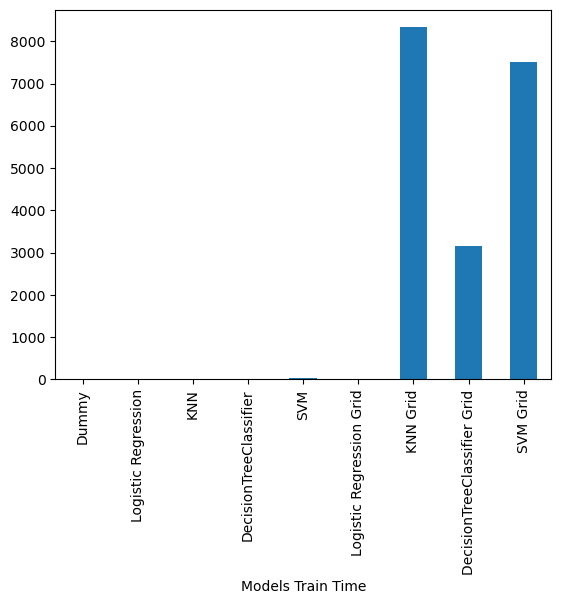

In [77]:
#results_df.drop('Train Time', axis = 1).plot(kind='bar', stacked=True)
results_df['Train Time'].plot(kind='bar', stacked=True)
plt.xlabel('Models Train Time')
plt.show()

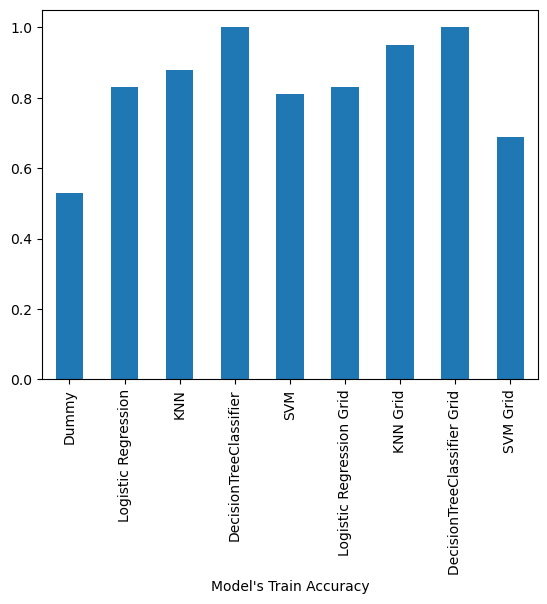

In [61]:
results_df['Train Accuracy'].plot(kind='bar', stacked=True)
plt.xlabel("Model's Train Accuracy")
plt.show()

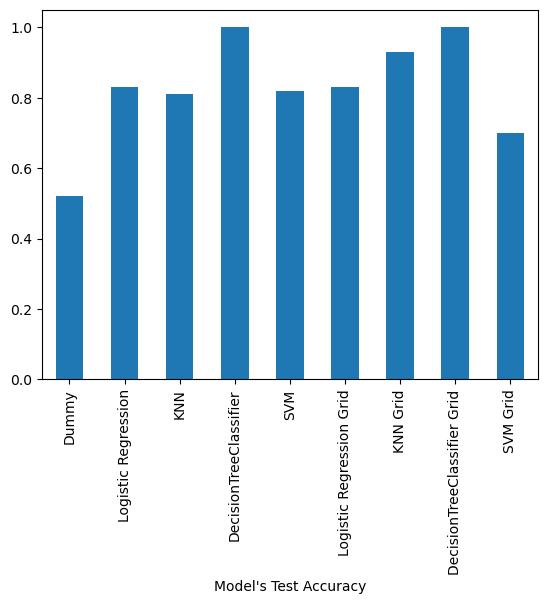

In [80]:
results_df['Test Accuracy'].plot(kind='bar', stacked=True)
plt.xlabel("Model's Test Accuracy")
plt.show()

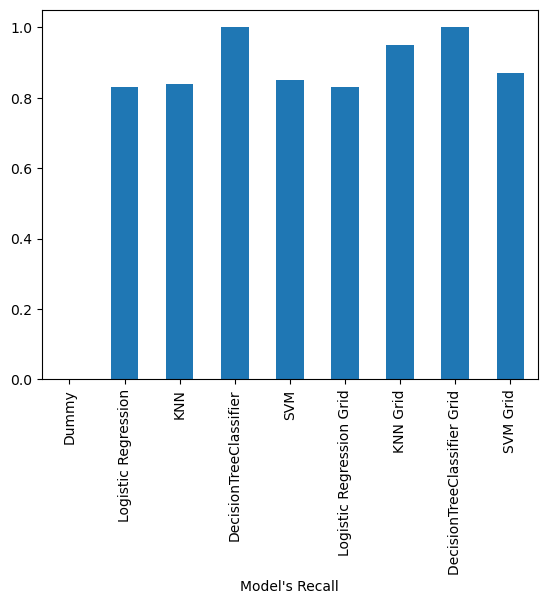

In [66]:
results_df['Recall'].plot(kind='bar', stacked=True)
plt.xlabel("Model's Recall")
plt.show()

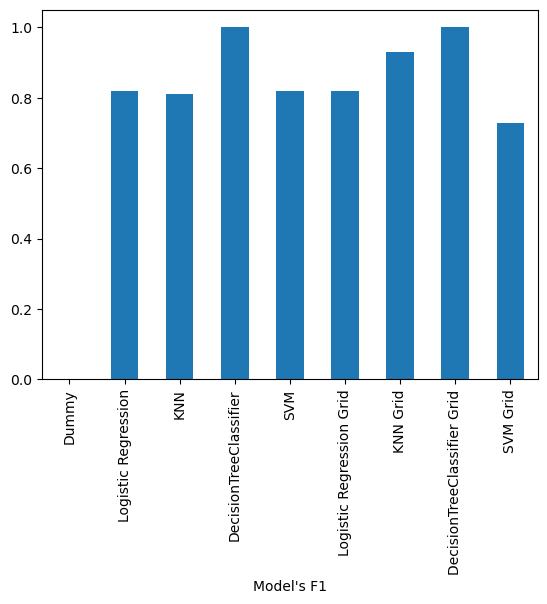

In [67]:
results_df['F1'].plot(kind='bar', stacked=True)
plt.xlabel("Model's F1")
plt.show()

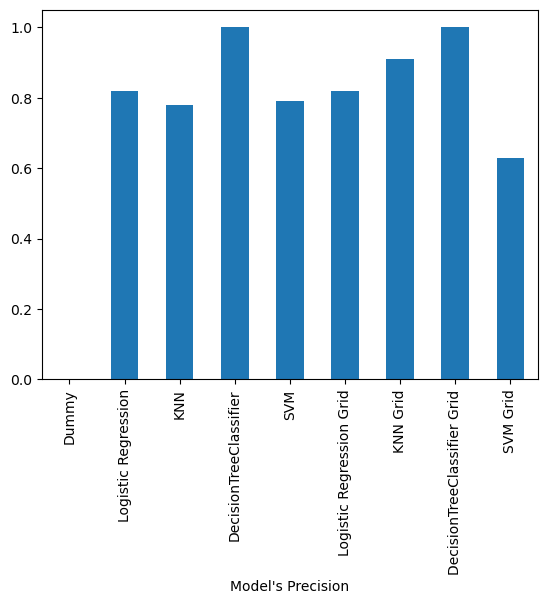

In [81]:
results_df['Precision'].plot(kind='bar', stacked=True)
plt.xlabel("Model's Precision")
plt.show()

results_df['Precision'].plot(kind='bar', stacked=True)
plt.xlabel("Model's Precision")
plt.show()

### Feture Importance

Precision: 0.91
Recall: 0.95
Accuracy: 0.93
F1: 0.93
time: 241.60
Pipeline(steps=[('scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_neighbors=12, p=1))])
The accuracy train 95.02%
The accuracy test 93.06%


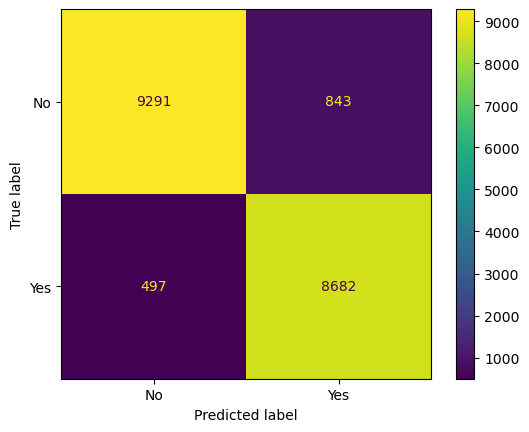

In [79]:
best_est = process_model_grid('KNN Grid', GridSearchCV(estimator=pipe_KNN, param_grid=param_grid_knn, cv=5), X_train, y_train, X_test, y_test)
best_estimator_final = best_est
importances = permutation_importance(best_estimator_final, X_train, y_train, n_repeats = 10, random_state=40)

In [82]:
importances_tr = dict(zip(X_train.columns, importances.importances_mean))
importances_tr = {k : v for k ,v in sorted(importances_tr.items(), key = lambda x: x[1], reverse = True)}

import_df = pd.DataFrame(importances_tr.values(), index=importances_tr.keys(), columns = ['Importances'])
display(import_df)

,Importances
Payment Delay,0.247414
Support Calls,0.123164
Tenure,0.082570
Gender,0.070853
Usage Frequency,0.043554
Total Spend,0.032436
Contract Length,0.027458
Age,0.025406
Last Interaction,0.002339
Subscription Type,0.001607


<Axes: >

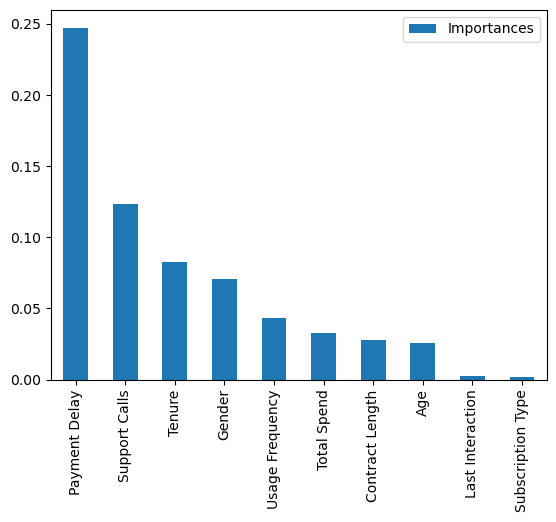

In [83]:
import_df.plot(kind='bar', stacked=True)